# 시작

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12259 (delta 6), reused 1 (delta 0), pack-reused 12249
Receiving objects: 100% (12259/12259), 13.47 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (8552/8552), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


Scaling
Scaling은 이미지의 사이즈가 변하는 것 입니다. OpenCV에서는 cv2.resize() 함수를 사용하여 적용할 수 있습니다. 사이즈가 변하면 pixel사이의 값을 결정을 해야 하는데, 이때 사용하는 것을 보간법(Interpolation method)입니다. 많이 사용되는 보간법은 사이즈를 줄일 때는 cv2.INTER_AREA , 사이즈를 크게할 때는 cv2.INTER_CUBIC , cv2.INTER_LINEAR 을 사용합니다.

cv2.resize(img, dsize, fx, fy, interpolation)
Parameters:	
img – Image
dsize – Manual Size. 가로, 세로 형태의 tuple(ex; (100,200))
fx – 가로 사이즈의 배수. 2배로 크게하려면 2. 반으로 줄이려면 0.5
fy – 세로 사이즈의 배수
interpolation – 보간법

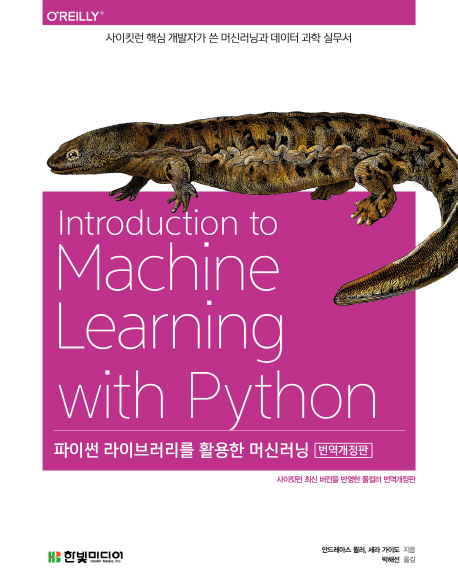

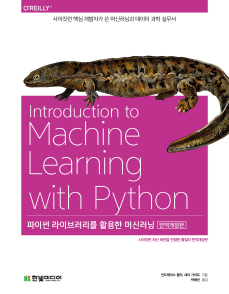

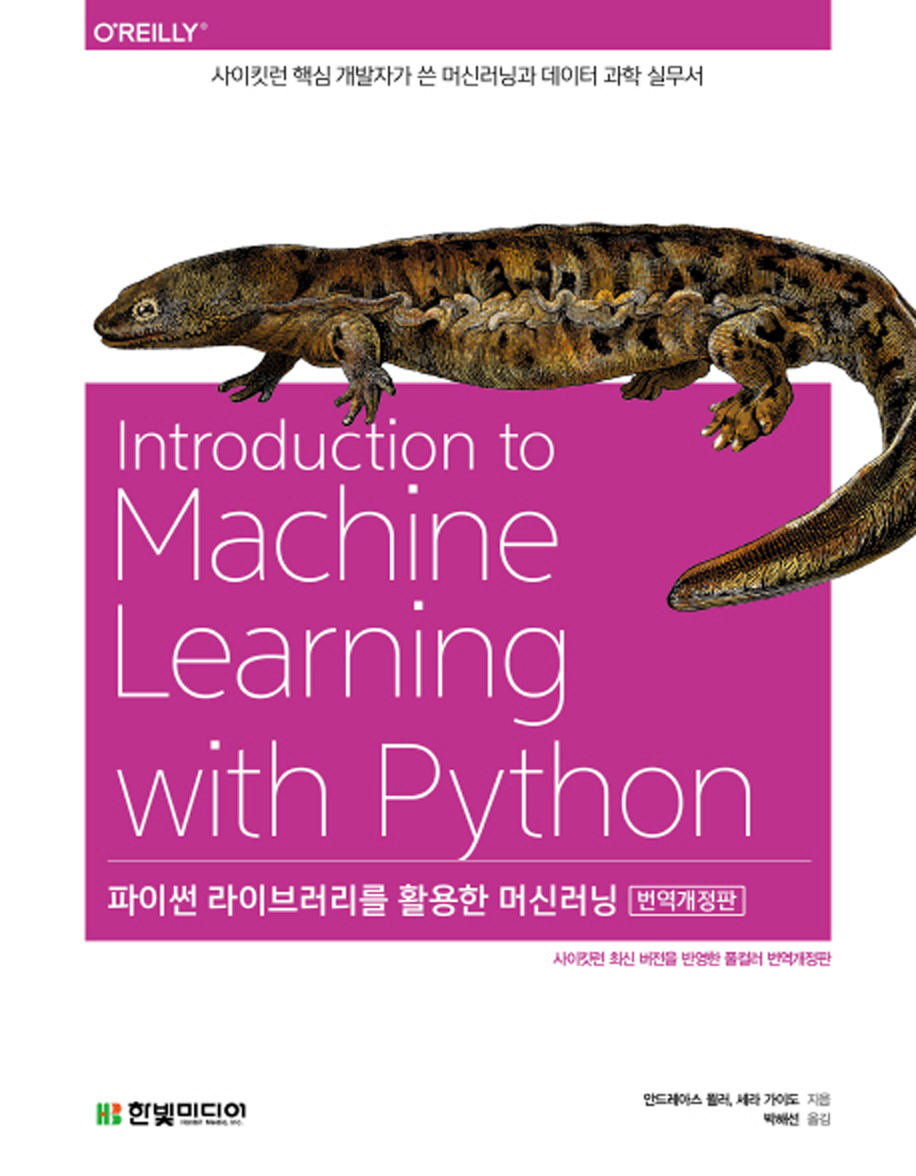

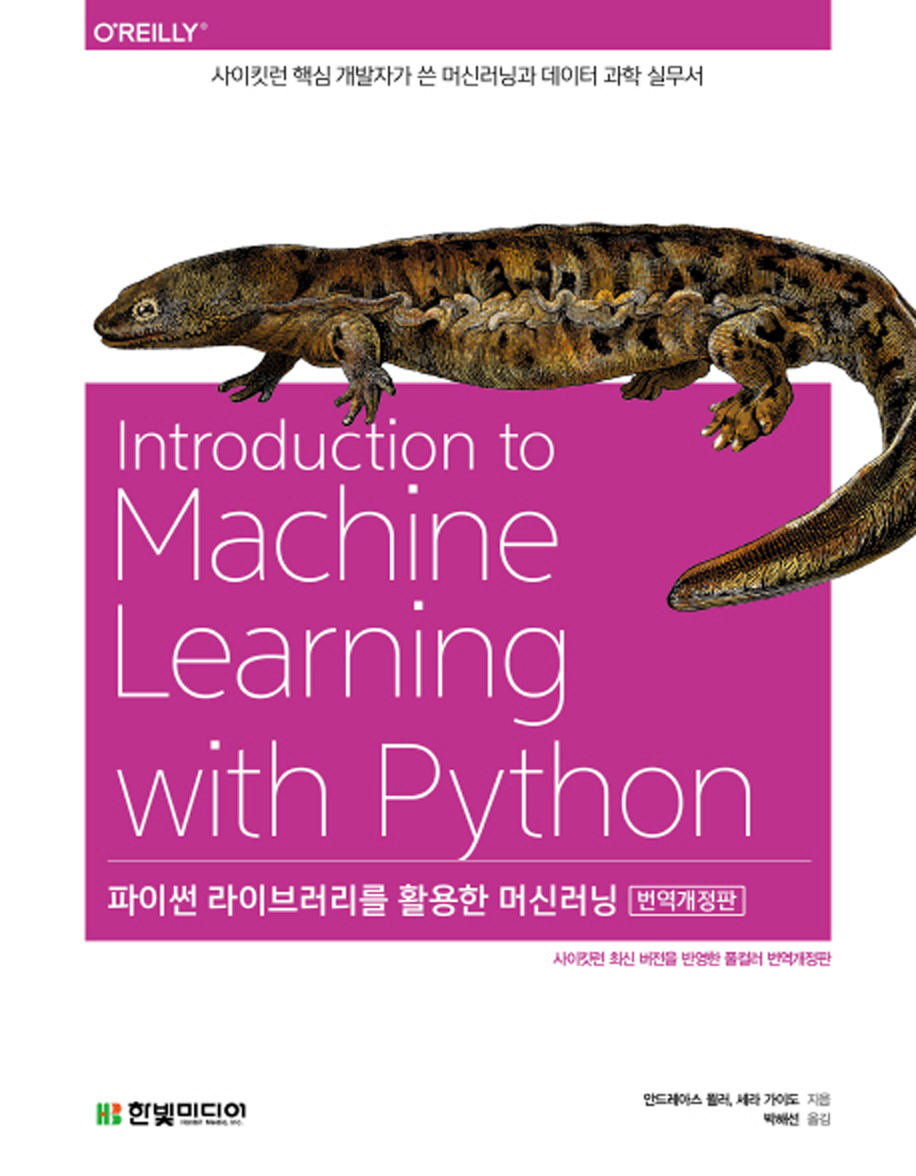

In [ ]:
#-*- coding:utf-8 -*-
from google.colab.patches import cv2_imshow
import numpy as np

img = cv2.imread('/gdrive/MyDrive/Colab Notebooks/Intro_ML/introduction_to_ml_with_python-master/introduction_to_ml_with_python-master/cover.jpg')

# 행 : Height, 열:width
height, width = img.shape[:2]

# 이미지 축소
shrink = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

# Manual Size지정
zoom1 = cv2.resize(img, (width*2, height*2), interpolation=cv2.INTER_CUBIC)

# 배수 Size지정
zoom2 = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)


cv2_imshow(img)
cv2_imshow(shrink)
cv2_imshow(zoom1)
cv2_imshow(zoom2)


# Dataset

In [ ]:
# defining the files directory and testing directory
train_dir = '/gdrive/MyDrive/Colab Notebooks/PyTorch/Fruit Image Detection/train_zip/train'
test_dir = '/gdrive/MyDrive/Colab Notebooks/PyTorch/Fruit Image Detection/test_zip/test'
classes = [_, 'apple','banana','orange']

class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir)) #경로에 위치한 폴더 안의 파일 이름들이 리스트로 뽑힘
                        if image[-4:]=='.jpg'] # 그중에서 jpg 파일 형태만 그 이름을 저장
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name) # 폴더 경로 + 파일 이름

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA) #보간법 중 하나
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        #torch는 String 리스트를 받을 수 없음 ㅠㅠ
        #target["classes"] = classes
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
trainset = FruitImagesDataset(train_dir, 224, 224)
print('length of dataset = ', len(trainset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = trainset[78]
print(img.shape, '\n',target)

length of dataset =  240 

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


# Visualization

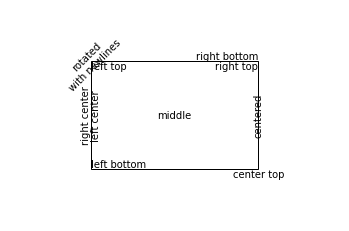

In [ ]:
import matplotlib.pyplot as plt

# Build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=False)
p.set_transform(ax.transAxes)
p.set_clip_on(False)
ax.add_patch(p)


ax.text(left, top, 'left top',
        horizontalalignment='left',
        verticalalignment='top')
        #transform=ax.transAxes)

ax.text(left, bottom, 'left bottom',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)

ax.text(right, top, 'right bottom',
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes)

ax.text(right, top, 'right top',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

ax.text(right, bottom, 'center top',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax.transAxes)

ax.text(left, 0.5 * (bottom + top), 'right center',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)

ax.text(left, 0.5 * (bottom + top), 'left center',
        horizontalalignment='left',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)

ax.text(0.5 * (left + right), 0.5 * (bottom + top), 'middle',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

ax.text(right, 0.5 * (bottom + top), 'centered',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)

ax.text(left, top, 'rotated\nwith newlines',
        horizontalalignment='center',
        verticalalignment='center',
        rotation=45,
        transform=ax.transAxes)

plt.axis('off')

plt.show()


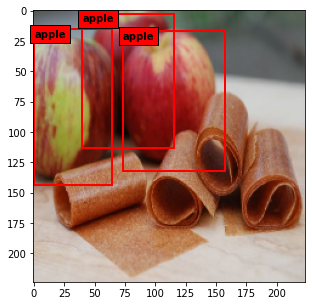

(224, 224, 3) 
 {'boxes': tensor([[ 73.1779,  16.9541, 157.6933, 132.5505],
        [  0.3436,  15.4128,  64.5890, 143.8532],
        [ 39.8528,   2.5688, 115.7791, 113.0275]]), 'labels': tensor([1, 1, 1]), 'area': tensor([9769.6621, 8251.7031, 8386.7305]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([2])}


In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for i, box in enumerate(target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
                                 
        
        # Draw the bounding box on top of the image
        a.add_patch(rect)
        a.text(x, y,classes[target['labels'][i]],
               horizontalalignment='left',
               verticalalignment='top',
               fontweight='bold',
               color='black',
               bbox=dict(facecolor='red', alpha=1))
               

    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = trainset[2]
plot_img_bbox(img, target)
print(img.shape, '\n',target)

# Modelling

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Augmentations

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

from engine import train_one_epoch, evaluate


import utils

import transforms as T

import albumentations as A

from albumentations.pytorch.transforms import ToTensor

In [ ]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensor(1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensor(1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Dataloaders

In [ ]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(train_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(train_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, collate_fn=utils.collate_fn)

valid_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False,collate_fn=utils.collate_fn)


# Training

In [ ]:
import math
import sys
import time
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step(loss_value)

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.005)


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,threshold=0.01,patience=5,min_lr=1e-10)
#StepLR(optimizer,step_size=5,last_epoch=-1)



# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step(loss_value)
    # evaluate on the test dataset
    evaluate(model, valid_loader, device=device)

Epoch: [0]  [ 0/12]  eta: 0:00:21  lr: 0.001882  loss: 2.0609 (2.0609)  loss_classifier: 1.6928 (1.6928)  loss_box_reg: 0.3558 (0.3558)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 1.8333  data: 0.2712  max mem: 11577
Epoch: [0]  [10/12]  eta: 0:00:03  lr: 0.000468  loss: 0.5276 (0.8773)  loss_classifier: 0.2589 (0.5755)  loss_box_reg: 0.2500 (0.2904)  loss_objectness: 0.0049 (0.0050)  loss_rpn_box_reg: 0.0060 (0.0065)  time: 1.8783  data: 0.3244  max mem: 11578
Epoch: [0]  [11/12]  eta: 0:00:01  lr: 0.000419  loss: 0.5135 (0.8417)  loss_classifier: 0.2575 (0.5461)  loss_box_reg: 0.2486 (0.2843)  loss_objectness: 0.0041 (0.0049)  loss_rpn_box_reg: 0.0060 (0.0064)  time: 1.8781  data: 0.3243  max mem: 11578
Epoch: [0] Total time: 0:00:22 (1.8783 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:02  model_time: 0.6899 (0.6899)  evaluator_time: 0.0091 (0.0091)  time: 0.9229  data: 0.2118  max mem: 11578
Test:  [2/3]  eta: 0:00:00  model_time: 

# Test

In [ ]:
# pick one image from the test set
img, target = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  53
real #boxes:  1


EXPECTED OUTPUT


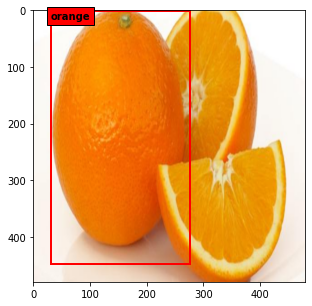

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


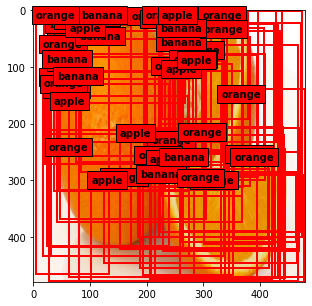

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

# Application of Non-maximum Suppression

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')



NMS APPLIED MODEL OUTPUT


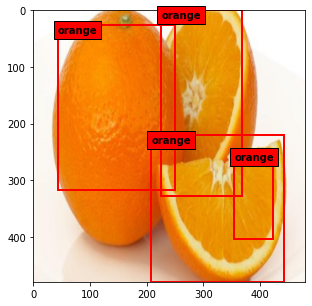

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# Final Test

EXPECTED OUTPUT



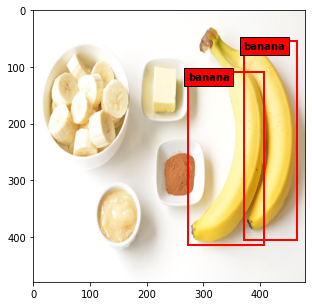

MODEL OUTPUT



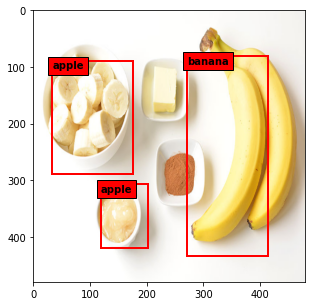

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[33]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.001)

plot_img_bbox(torch_to_pil(img), nms_prediction)


EXPECTED OUTPUT



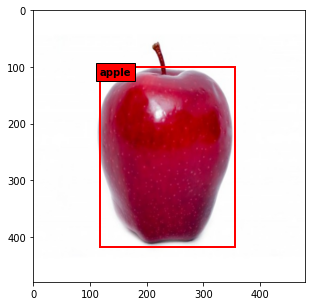

MODEL OUTPUT



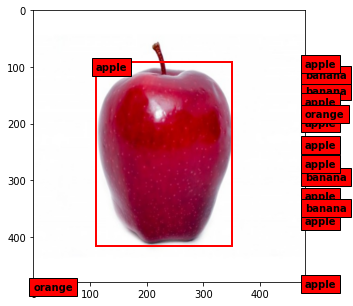

In [ ]:
img, target = test_dataset[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)
